In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import xlsxwriter

file = 'schedule_final.xls'
schedule = pd.read_excel(file)

In [299]:
#filter out walk time == 999 or 0
valid_walk_time_schedule = schedule[schedule['walk_time'] < 999]
valid_walk_time_schedule = valid_walk_time_schedule[valid_walk_time_schedule['walk_time'] > 0]

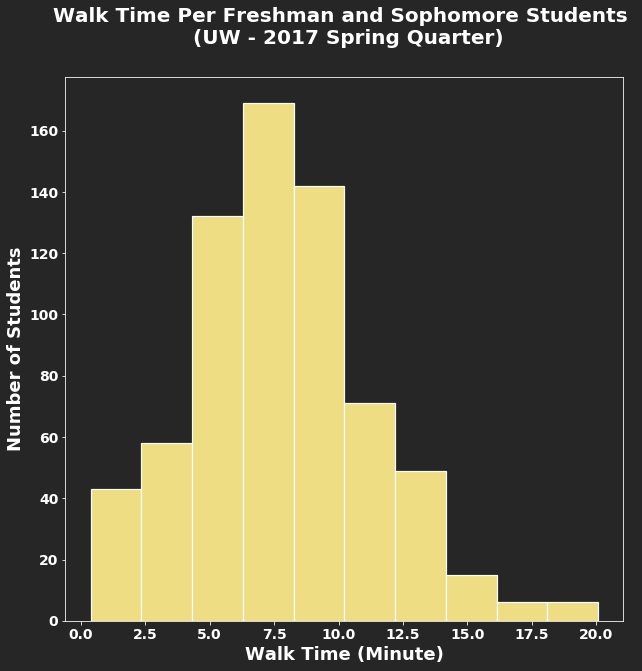

In [470]:
#Average walk time per students
Average_walk_time = pd.DataFrame(valid_walk_time_schedule.groupby('Key')['walk_time'].mean())

time = Average_walk_time['walk_time']

fig, ax = plt.subplots(facecolor='#262626ff')
time.plot(kind='hist', ax=ax, color='#eedd82', edgecolor='white', linewidth=1.2, fontsize=14)
ax.set_facecolor('#262626ff')

xlabel("Walk Time (Minute)", fontsize=18, fontweight = 'bold')
ylabel("Number of Students",fontsize=18, fontweight = 'bold')
title("Walk Time Per Freshman and Sophomore Students \n (UW - 2017 Spring Quarter)",fontsize=20,fontweight='bold').set_position([.5, 1.05])

plt.rcParams["figure.figsize"] = [10,10]


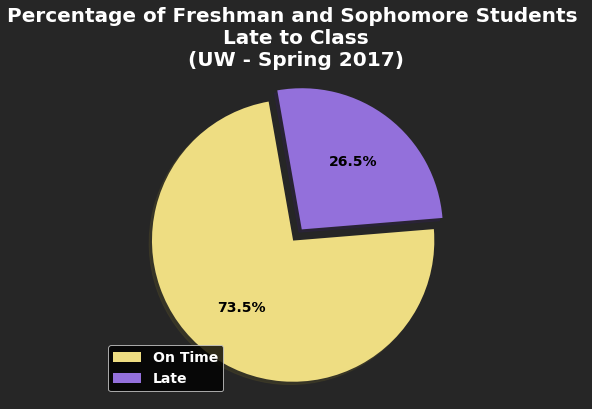

In [473]:
#percentage of students walked over 10 mins to at least one of their classes

#Total Population
total_population = valid_walk_time_schedule.loc[:,['Key']].drop_duplicates().shape[0]

#Calculating the number of students walked over 10 mins to at least one of their classes
stu_time_df = valid_walk_time_schedule.loc[:,['Key', 'walk_time']]
grouped = stu_time_df.groupby('Key')
stu_time_df['no_walk_over_ten'] = grouped['walk_time'].transform(lambda x: len(x[x>10]))

stu_over10 = stu_time_df.loc[stu_time_df['no_walk_over_ten'] > 0]
no_stu_over10 = stu_over10.loc[:,['Key']].drop_duplicates().shape[0]

#Creating pie chart
labels = 'On Time', 'Late'
sizes = [(total_population - no_stu_over10), no_stu_over10]
colors = ['#eedd82', '#9370db']
explode = (0, 0.1) 

fig = plt.figure()
fig.patch.set_facecolor('#262626ff')

_, _, graphs = pie(sizes, explode=explode, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)

plt.title('Percentage of Freshman and Sophomore Students \n Late to Class \n(UW - Spring 2017)', fontsize=20,fontweight='bold')
plt.rcParams["figure.figsize"] = [7,6]
plt.legend(labels, loc=3,prop={'size': 14})
for graph in graphs:
    graph.set_color('black')
    
plt.axis('equal')
plt.show()

In [153]:
class_1 = valid_walk_time_schedule[valid_walk_time_schedule['walk_time'] >= 10]
class_2 = class_1['OID'] + 1

In [336]:
def createDFfromTable(serie_n, table_n):
    li = serie_n.tolist()
    return table_n[table_n['OID'].isin(li)].reset_index(drop=True)

class1_df = createDFfromTable(class_1['OID'], schedule)
class2_df = createDFfromTable(class_2, schedule)

impacted_class_df = pd.merge(class1_df[['Key', 'Course', 'Location', 'space', 'walk_time']], 
                             class2_df[['Course', 'Location', 'space']], left_index=True, right_index=True)
impacted_class_df.rename(columns={'Course_x': 'Class1','Course_y': 'Class2',
                                  'Location_x': 'Classroom1','Location_y': 'Classroom2'}, inplace=True)
impacted_class_df = impacted_class_df.drop_duplicates().reset_index(drop=True)

In [408]:
impacted_class_df = impacted_class_df.sort_values(['space_x', 'space_y'])

# Group the data frame by month and item and extract a number of stats from each group
impacted_class_df['Count'] = impacted_class_df.groupby(['space_x', 'space_y'])['Key'].transform('count')

In [467]:
#the columns kept for flow mapping
headers = list(impacted_class_df)[1:(len(list(impacted_class_df)))]

flow_map_table = impacted_class_df.loc[:,headers].drop_duplicates()

In [536]:
# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('flow_map_table.xlsx')
worksheet = workbook.add_worksheet()

# Create header
for col_i, header in enumerate(headers):
    worksheet.write(0, col_i, header)
    

# Start from the A2 cell.
row = 1
col = 0

# Iterate over the data and write it out row by row.
for index, t_row in flow_map_table.iterrows():
    for i, each_col in enumerate(t_row):
        worksheet.write(row, i, each_col)
    row += 1

workbook.close()

#flow_map_table.to_csv('flow_map_table.csv')

In [510]:
One_stu_late = impacted_class_df[impacted_class_df['Count'] < 2].shape[0]
Two_more = impacted_class_df[impacted_class_df['Count'] > 1]
Two_or_three_more = Two_more[Two_more['Count'] < 4].shape[0]
Four_more_stu_late = Two_more[Two_more['Count'] > 3].shape[0]

In [527]:
#define metrics list variable to store the metrics
m_list = []

def writeMetrics(text, value, comment):
    m = [text, value, comment]
    m_list.append(m)

In [528]:
#to write more metrics
writeMetrics("Total Sampled Population", total_population, "Freshman and Sophomore Only")

writeMetrics("Number of Freshman and Sophomore Students Late to Class (Count)", 
             no_stu_over10, "")

writeMetrics("Percentage of Students Late to Class (%)", round((no_stu_over10/total_population)*100), 
             "")

writeMetrics("Number of Pathways with over 10-minute walk", flow_map_table.shape[0], "")

writeMetrics("Maximum Number of Freshman and Sophomore Students Impacted per Pathway", 
             impacted_class_df['Count'].max(),"")

writeMetrics("Number of Classes Having 1 Student Late", One_stu_late, 
             "It is Difficult to Improve This Situation")

writeMetrics("Number of Classes Having at Least 2 or 3 Students Late", Two_or_three_more,
             "")

writeMetrics("Number of Classes Having at Least 4 Students Late", Four_more_stu_late,
             "These are the classrooms should be moved to lower the number")

In [533]:
# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('metrics.xlsx')
worksheet = workbook.add_worksheet()

# Create header
worksheet.write(0, 0,     "Metric")
worksheet.write(0, 1, "Value")
worksheet.write(0, 2, "Comment")

# Start from the A2 cell.
row = 1
col = 0

# Iterate over the data and write it out row by row.
for metric, value, comment in (m_list):
    worksheet.write(row, col,     metric)
    worksheet.write(row, col + 1, value)
    worksheet.write(row, col + 2, comment)
    row += 1

workbook.close()